# 量子ニューラル・ネットワーク技術入門 - チュートリアル

このチュートリアルはQiskit Machine learning docsから作成しました。https://qiskit.org/ecosystem/machine-learning/locale/ja_JP/tutorials/01_neural_networks.html


# 量子ニューラル・ネットワーク

## 概要

このノートブックでは、 `qiskit-machine-learning` で提供されるさまざまな量子ニューラルネットワーク (QNN) の実装と、それらを基本的な量子機械学習 (QML) ワークフローに統合する方法について説明します。

このチュートリアルの構造は以下のとおりです。

1. [はじめに](#1.-Implementation-in-`qiskit-machine-learning`)
2. [SamplerQNN](#2.`SamplerQNN`)
3. [フォワード・パスの実行方法](#3.-How-to-Run-a-Forward-Pass)
4. [バックワード・パスの実行方法](#4.-How-to-Run-a-Backward-Pass)
5. [拡張機能](#5.-Advanced-Functionality)
6. [結論](#6.-Conclusion)

## 1.  `qiskit-machine-learning` での実装

`qiskit-machine-learning` のQNNはアプリケーションに依存しない計算ユニットであり、様々なユースケースに使用できます。

このモジュールには、QNNのインターフェースと 2 つの特定の実装が含まれています。

1. [NeuralNetwork](https://qiskit.org/ecosystem/machine-learning/stubs/qiskit_machine_learning.neural_networks.NeuralNetwork.html): ニューラルネットワークのインターフェイス。これは全ての QNN が継承する抽象クラスです。。
2. [EstimatorQNN](https://qiskit.org/ecosystem/machine-learning/stubs/qiskit_machine_learning.neural_networks.EstimatorQNN.html): 量子力学的観測可能量（オブザーバブル）の評価に基づくネットワーク。
3. [SamplerQNN](https://qiskit.org/ecosystem/machine-learning/locale/fr_FR/stubs/qiskit_machine_learning.neural_networks.SamplerQNN.html): 量子回路の測定から得られたサンプルを基にしたネットワーク。
 
これらの実装は  [qiskit primitives](https://qiskit.org/documentation/apidoc/primitives.html) に基づいています。それぞれの実装である `EstimatorQNN` と `SamplerQNN` は、対応するprimitive (`BaseEstimator` と `BaseSampler` の任意のサブクラス) のオプション・インスタンスを取り込みます。

***

それでは、2つの `NeuralNetwork` 実装の具体例を見てみましょう。しかしその前に、実行のたびに結果が変わらないように、アルゴリズムのseedを設定します。

In [1]:
from qiskit.utils import algorithm_globals

algorithm_globals.random_seed = 42

## 2. `SamplerQNN`

`SamplerQNN` は、 `EstimatorQNN` と同様にインスタンス化されます。 

  - しかし、量子回路の測定から直接サンプルを吸収するので、カスタムのオブザーバブルを必要としません。

これらの出力サンプルは、デフォルトでは、ビット文字列に対応する整数インデックスを測定する確率として解釈されます。

ただし、 `SamplerQNN` ではサンプルを後処理するための `interpret` 関数を指定することもできます。 この関数は (ビット文字列から) 測定された整数を取って、それを新しい値、すなわち非負の整数にマップするように定義する必要があります。

`SamplerQNN` 用に別の量子回路を作成しましょう。 この場合、2 つの入力パラメーターと 4 つの訓練可能な重みを持ち、Two-local 回路をパラメーター化します。

input parameters: ['input[0]', 'input[1]']
weight parameters: ['weight[0]', 'weight[1]', 'weight[2]', 'weight[3]']


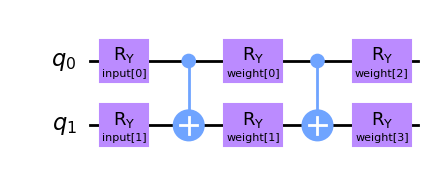

In [5]:
from qiskit.circuit import QuantumCircuit, ParameterVector

inputs2 = ParameterVector("input", 2)
weights2 = ParameterVector("weight", 4)
print(f"input parameters: {[str(item) for item in inputs2.params]}")
print(f"weight parameters: {[str(item) for item in weights2.params]}")

qc2 = QuantumCircuit(2)
qc2.ry(inputs2[0], 0)
qc2.ry(inputs2[1], 1)
qc2.cx(0, 1)
qc2.ry(weights2[0], 0)
qc2.ry(weights2[1], 1)
qc2.cx(0, 1)
qc2.ry(weights2[2], 0)
qc2.ry(weights2[3], 1)

qc2.draw(output="mpl")


`EstimatorQNN` と同様に、 `SamplerQNN` をインスタンス化する際に入力と重みを指定する必要があります。 この場合、キーワード引数は以下のようになります: 
- `sampler`: オプションのprimitiveインスタンス 
- `input_params`: 「ネットワーク入力」として扱われるべき量子回路パラメーターのリスト 
- `weight_params`: 「ネットワーク重み」として扱われるべき量子回路パラメーターのリスト

再び、 `Sampler` インスタンスを QNN に設定せず、デフォルトにしていることに注意してください。

In [7]:
from qiskit_machine_learning.neural_networks import SamplerQNN

sampler_qnn = SamplerQNN(circuit=qc2, input_params=inputs2, weight_params=weights2)
sampler_qnn


上記の基本的な引数に加えて、 `SamplerQNN` は `input_gradients` と `interpret` と `output_shape` の 3 つの設定を受け付けます。 これらはセクション4とセクション5で紹介されます。

## 3. フォワード・パスの実行方法

### 3.1. セットアップ

実際の設定では、入力はデータセットによって定義され、重みは学習アルゴリズムや学習済みモデルの一部として定義されます。しかし、このチュートリアルのために、適切な次元の入力と重みのランダムなセットを指定します。

In [8]:
sampler_qnn_input = algorithm_globals.random.random(sampler_qnn.num_inputs)
sampler_qnn_weights = algorithm_globals.random.random(sampler_qnn.num_weights)

In [9]:
print(
    f"Number of input features for SamplerQNN: {sampler_qnn.num_inputs} \nInput: {sampler_qnn_input}"
)
print(
    f"Number of trainable weights for SamplerQNN: {sampler_qnn.num_weights} \nWeights: {sampler_qnn_weights}"
)

Number of input features for SamplerQNN: 2 
Input: [0.77395605 0.43887844]
Number of trainable weights for SamplerQNN: 4 
Weights: [0.85859792 0.69736803 0.09417735 0.97562235]


入力と重みを設定したら、バッチパスと非バッチパスの結果を確認しましょう。

### 3.2. 非バッチ・フォワード・パス



`SamplerQNN` (カスタム interpret 関数なし) では、フォワード・パスの期待される出力形状は `(1, 2**num_qubits)` になります。 カスタム interpret 関数を使用すると、出力形状は `(1, output_shape)` になります。ここで、`1` はサンプル数です。

In [10]:
sampler_qnn_forward = sampler_qnn.forward(sampler_qnn_input, sampler_qnn_weights)

print(
    f"Forward pass result for SamplerQNN: {sampler_qnn_forward}.  \nShape: {sampler_qnn_forward.shape}"
)

Forward pass result for SamplerQNN: [[0.23851185 0.1411135  0.3367757  0.28359895]].  
Shape: (1, 4)


### 3.3. バッチ・フォワード・パス


`SamplerQNN` (カスタム interpret 関数なし) では、フォワード・パスの期待される出力形状は `(batch_size, 2**num_qubits)` になります。 カスタム interpret 関数を使用すると、出力形状は `(batch_size, output_shape)` になります。

In [11]:
sampler_qnn_forward_batched = sampler_qnn.forward(
    [sampler_qnn_input, sampler_qnn_input], sampler_qnn_weights
)

print(
    f"Forward pass result for SamplerQNN: {sampler_qnn_forward_batched}.  \nShape: {sampler_qnn_forward_batched.shape}"
)

Forward pass result for SamplerQNN: [[0.23851185 0.1411135  0.3367757  0.28359895]
 [0.23851185 0.1411135  0.3367757  0.28359895]].  
Shape: (2, 4)


## 4. バックワード・パスの実行方法

上記で定義した入力と重みを利用して、バックワード・パスの動作を示しましょう。このパスはタプル `(input_gradients, weight_gradients)` を返します。 デフォルトでは、バックワード・パスは重みパラメーターに対する勾配のみを計算します。

入力パラメーターに対して勾配を有効にする場合は、QNN インスタンスを作成するときに次のフラグを設定する必要があります。

```python
qnn = ...QNN(..., input_gradients=True)
```


PyTorchとの統合に `TorchConnector` を使用するには、入力勾配が **必要** であることを忘れないでください。

### 4.1. 入力勾配のないバックワード・パス


`SamplerQNN` (カスタム interpret 関数なし) では、フォワード・パスの期待される出力形状は `(batch_size, 2**num_qubits, num_weights) `になります。 カスタム interpret 関数を使用すると、出力形状は `(batch_size, output_shape, num_weights)` になります。

In [12]:
sampler_qnn_input_grad, sampler_qnn_weight_grad = sampler_qnn.backward(
    sampler_qnn_input, sampler_qnn_weights
)

print(
    f"Input gradients for SamplerQNN: {sampler_qnn_input_grad}.  \nShape: {sampler_qnn_input_grad}"
)
print(
    f"Weight gradients for SamplerQNN: {sampler_qnn_weight_grad}.  \nShape: {sampler_qnn_weight_grad.shape}"
)

Input gradients for SamplerQNN: None.  
Shape: None
Weight gradients for SamplerQNN: [[[ 0.00609879 -0.30661818 -0.1834591  -0.28341665]
  [-0.02969169  0.17866236  0.1834591  -0.20004909]
  [-0.37812738  0.30266095 -0.30904568  0.28341665]
  [ 0.40172028 -0.17470512  0.30904568  0.20004909]]].  
Shape: (1, 4, 4)


### 4.2. 入力勾配のあるバックワード・パス

`input_gradients` を有効にして、このオプションで期待される出力サイズを表示しましょう。

In [13]:
sampler_qnn.input_gradients = True

#### 4.2.2. `SamplerQNN` の例

`SamplerQNN` (カスタム interpret 関数なし) では、入力勾配に対する期待される出力形状は `(batch_size, 2**num_qubits, num_inputs)` になります。 カスタム interpret 関数を使用すると、出力形状は `(batch_size, output_shape, num_inputs)` になります。

In [14]:
sampler_qnn_input_grad, sampler_qnn_weight_grad = sampler_qnn.backward(
    sampler_qnn_input, sampler_qnn_weights
)

print(
    f"Input gradients for SamplerQNN: {sampler_qnn_input_grad}.  \nShape: {sampler_qnn_input_grad.shape}"
)
print(
    f"Weight gradients for SamplerQNN: {sampler_qnn_weight_grad}.  \nShape: {sampler_qnn_weight_grad.shape}"
)

Input gradients for SamplerQNN: [[[ 0.00854017 -0.4260793 ]
  [ 0.29208826  0.08375938]
  [-0.35915753  0.17972714]
  [ 0.05852911  0.16259278]]].  
Shape: (1, 4, 2)
Weight gradients for SamplerQNN: [[[ 0.00609879 -0.30661818 -0.1834591  -0.28341665]
  [-0.02969169  0.17866236  0.1834591  -0.20004909]
  [-0.37812738  0.30266095 -0.30904568  0.28341665]
  [ 0.40172028 -0.17470512  0.30904568  0.20004909]]].  
Shape: (1, 4, 4)


## 5. 拡張機能

### カスタム `interpret` 付き `SamplerQNN`


`SamplerQNN` の一般的な `interpret` メソッドの 1 つは `parity` 関数で、バイナリ分類を行うことができます。 インスタンス作成のセクションで説明したように、interpret 関数を使うことで、フォワードとバックワード・パスの出力形状が変更されます。 パリティinterpret関数の場合、 `output_shape` は `2` に固定されます。 そこで期待される前方および重み勾配の形状は、おそれぞれ `(batch_size, 2)` と `(batch_size, 2, num_weights)` です。

In [15]:
parity = lambda x: "{:b}".format(x).count("1") % 2
output_shape = 2  # parity = 0, 1

sampler_qnn2 = SamplerQNN(
    circuit=qc2,
    input_params=inputs2,
    weight_params=weights2,
    interpret=parity,
    output_shape=output_shape,
)

In [16]:
sampler_qnn_forward2 = sampler_qnn2.forward(sampler_qnn_input, sampler_qnn_weights)
sampler_qnn_input_grad2, sampler_qnn_weight_grad2 = sampler_qnn2.backward(
    sampler_qnn_input, sampler_qnn_weights
)

print(f"Forward output for SamplerQNN1: {sampler_qnn_forward.shape}")
print(f"Forward output for SamplerQNN2: {sampler_qnn_forward2.shape}")
print(f"Backward output for SamplerQNN1: {sampler_qnn_weight_grad.shape}")
print(f"Backward output for SamplerQNN2: {sampler_qnn_weight_grad2.shape}")

Forward output for SamplerQNN1: (1, 4)
Forward output for SamplerQNN2: (1, 2)
Backward output for SamplerQNN1: (1, 4, 4)
Backward output for SamplerQNN2: (1, 2, 4)


## 6. 結論


このチュートリアルでは、 `qiskit-machine-learning` によって提供される2つのニューラルネットワーク・クラス、つまり `EstimatorQNN` と `SamplerQNN` について紹介しました。 QNN初期化のための重要なステップ、フォワードおよびバックワード・パスでの基本的な使用法、および高度な機能のいくつかの理論的背景を提供しました。

この問題設定を扱って、さまざまな回路のサイズ、入力、重みパラメーターの長さが、出力形状にどのように影響を与えるか確認することをお勧めします。

In [48]:
import qiskit.tools.jupyter

%qiskit_version_table
%qiskit_copyright